In [ ]:
import marimo as mo
import cyvcf2
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
def read_vcf_data():
    # Read the VCF file with pre-calculated DP and VAF
    vcf_path = "xhetrel/chrX.vcf.gz"
    reader = cyvcf2.Reader(vcf_path)

    # Dictionary to store genotype counts per sample for different depth ranges and VAF filters
    sample_genotypes = {
        'dp_0_10_vaf': {sample: Counter() for sample in reader.samples},
        'dp_0_10_no_vaf': {sample: Counter() for sample in reader.samples},
        'dp_10_20_vaf': {sample: Counter() for sample in reader.samples},
        'dp_10_20_no_vaf': {sample: Counter() for sample in reader.samples},
        'dp_20_plus_vaf': {sample: Counter() for sample in reader.samples},
        'dp_20_plus_no_vaf': {sample: Counter() for sample in reader.samples}
    }

    # Process variants
    for variant in reader:
        # Process each sample
        for i, sample in enumerate(reader.samples):
            # Get DP and VAF
            dp = variant.format('DP')[i][0]
            vaf_values = variant.format('VAF')

            # Skip if VAF is not available or NaN
            if vaf_values is None or np.isnan(vaf_values[i][0]):
                continue

            vaf = vaf_values[i][0]
            gt_type = variant.gt_types[i]

            # Skip UNKNOWN genotypes
            if gt_type == 2:
                continue

            # Process DP 0-10 range
            if 0 <= dp < 10:
                # With VAF filter
                if vaf >= 0.25:
                    if gt_type == 1:  # HET
                        sample_genotypes['dp_0_10_vaf'][sample]["0/1"] += 1
                    elif gt_type == 3:  # HOM_ALT
                        sample_genotypes['dp_0_10_vaf'][sample]["1/1"] += 1
                # Without VAF filter
                if gt_type == 1:  # HET
                    sample_genotypes['dp_0_10_no_vaf'][sample]["0/1"] += 1
                elif gt_type == 3:  # HOM_ALT
                    sample_genotypes['dp_0_10_no_vaf'][sample]["1/1"] += 1

            # Process DP 10-20 range
            elif 10 <= dp < 20:
                # With VAF filter
                if vaf >= 0.25:
                    if gt_type == 1:  # HET
                        sample_genotypes['dp_10_20_vaf'][sample]["0/1"] += 1
                    elif gt_type == 3:  # HOM_ALT
                        sample_genotypes['dp_10_20_vaf'][sample]["1/1"] += 1
                # Without VAF filter
                if gt_type == 1:  # HET
                    sample_genotypes['dp_10_20_no_vaf'][sample]["0/1"] += 1
                elif gt_type == 3:  # HOM_ALT
                    sample_genotypes['dp_10_20_no_vaf'][sample]["1/1"] += 1

            # Process DP ≥20 range
            elif dp >= 20:
                # With VAF filter
                if vaf >= 0.25:
                    if gt_type == 1:  # HET
                        sample_genotypes['dp_20_plus_vaf'][sample]["0/1"] += 1
                    elif gt_type == 3:  # HOM_ALT
                        sample_genotypes['dp_20_plus_vaf'][sample]["1/1"] += 1
                # Without VAF filter
                if gt_type == 1:  # HET
                    sample_genotypes['dp_20_plus_no_vaf'][sample]["0/1"] += 1
                elif gt_type == 3:  # HOM_ALT
                    sample_genotypes['dp_20_plus_no_vaf'][sample]["1/1"] += 1

    return sample_genotypes

def read_sample_sex():
    # Read sample sex information
    sex_path = "xhetrel/sample_sex"
    sex_df = pd.read_csv(sex_path, sep='\t', names=['Sample', 'Sex'])

    # Translate Turkish sex labels to English
    sex_translation = {
        'Kadın': 'female',
        'Erkek': 'male'
    }
    sex_df['Sex'] = sex_df['Sex'].map(sex_translation)

    # Remove samples with missing sex information
    sex_df = sex_df.dropna(subset=['Sex'])

    return sex_df


In [ ]:
# Get the data and calculate ratios for each depth range and VAF filter
genotype_counts = read_vcf_data()
sex_df = read_sample_sex()

def calculate_het_ratios(genotype_counts, sex_df):
    # Calculate heterozygosity ratio for each sample
    results = []
    for sample, counts in genotype_counts.items():
        het_count = counts.get("0/1", 0)
        hom_alt_count = counts.get("1/1", 0)
        total_het_hom = het_count + hom_alt_count

        if total_het_hom > 0:
            het_ratio = het_count / total_het_hom
            results.append({
                'Sample': sample,
                'Heterozygous_Ratio': het_ratio,
                'Total_Variants': sum(counts.values()),
                'Het_Variants': het_count,
                'Hom_Alt_Variants': hom_alt_count
            })

    # Create DataFrame and merge with sex information
    results_df = pd.DataFrame(results)
    results_df = results_df.merge(sex_df, on='Sample', how='inner')
    results_df = results_df.sort_values('Heterozygous_Ratio', ascending=False)
    return results_df

het_ratios_dfs = {
    'DP 0-10 (VAF ≥ 0.25)': calculate_het_ratios(genotype_counts['dp_0_10_vaf'], sex_df),
    'DP 0-10 (No VAF filter)': calculate_het_ratios(genotype_counts['dp_0_10_no_vaf'], sex_df),
    'DP 10-20 (VAF ≥ 0.25)': calculate_het_ratios(genotype_counts['dp_10_20_vaf'], sex_df),
    'DP 10-20 (No VAF filter)': calculate_het_ratios(genotype_counts['dp_10_20_no_vaf'], sex_df),
    'DP ≥20 (VAF ≥ 0.25)': calculate_het_ratios(genotype_counts['dp_20_plus_vaf'], sex_df),
    'DP ≥20 (No VAF filter)': calculate_het_ratios(genotype_counts['dp_20_plus_no_vaf'], sex_df)
}

# Print summary for each condition
for condition, df in het_ratios_dfs.items():
    print(f"\n{condition}:")
    print(f"Total samples: {len(df)}")
    print(f"Mean heterozygous ratio: {df['Heterozygous_Ratio'].mean():.3f}")
    print(f"Total variants: {df['Total_Variants'].sum()}")



DP 0-10 (VAF ≥ 0.25):
Total samples: 145
Mean heterozygous ratio: 0.248
Total variants: 40159

DP 0-10 (No VAF filter):
Total samples: 145
Mean heterozygous ratio: 0.249
Total variants: 40235

DP 10-20 (VAF ≥ 0.25):
Total samples: 145
Mean heterozygous ratio: 0.349
Total variants: 46118

DP 10-20 (No VAF filter):
Total samples: 145
Mean heterozygous ratio: 0.353
Total variants: 46462

DP ≥20 (VAF ≥ 0.25):
Total samples: 145
Mean heterozygous ratio: 0.349
Total variants: 153016

DP ≥20 (No VAF filter):
Total samples: 145
Mean heterozygous ratio: 0.350
Total variants: 153418


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_analysis_results(df, depth_range, model, X_test, y_test, y_pred_proba):
    """Plot various analysis results including scatter plot, ROC curve, precision-recall curve, and threshold analysis.

    Args:
        df: DataFrame containing the data
        depth_range: String describing the depth range and variant percentage
        model: Trained logistic regression model
        X_test: Test features
        y_test: True labels for test set
        y_pred_proba: Predicted probabilities for test set
    """
    # Plot scatter plot with decision boundary
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Heterozygous_Ratio', y='Sex', alpha=0.5, hue='Sex')

    # Plot decision boundary
    x_range = np.linspace(df['Heterozygous_Ratio'].min(), 
                        df['Heterozygous_Ratio'].max(), 100)
    y_range = model.predict_proba(x_range.reshape(-1, 1))[:, 1]
    plt.plot(x_range, y_range, 'r-', label='Decision Boundary')

    plt.title(f'Sex Prediction using Heterozygous Ratio ({depth_range})')
    plt.xlabel('Heterozygous Ratio')
    plt.ylabel('Sex')
    plt.legend()
    plt.show()

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({depth_range})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find optimal threshold (Youden's J statistic)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]

    # Calculate precision and recall for different thresholds
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({depth_range})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot threshold analysis
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tpr, label='True Positive Rate')
    plt.plot(thresholds, 1-fpr, label='True Negative Rate')
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal threshold: {optimal_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title(f'Threshold Analysis ({depth_range})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold

def analyze_depth_range(df, depth_range, variant_percentage=None, plot_results=True):
    """Analyze heterozygous ratios for a given depth range and variant percentage.

    Args:
        df: DataFrame containing the data
        depth_range: String describing the depth range
        variant_percentage: Optional float between 0 and 1 to select a random subset of variants
        plot_results: Boolean to control whether to generate plots

    Returns:
        tuple: (accuracy, auc, mw_pval, t_pval, cohens_d, optimal_threshold, avg_female_variants, avg_male_variants) metrics
    """
    # If variant_percentage is specified, randomly select that percentage of variants
    if variant_percentage is not None:
        # Calculate how many variants to keep for each sample
        df = df.copy()

        # Calculate valid variants (sum of het and hom_alt)
        df['Valid_Variants'] = df['Het_Variants'] + df['Hom_Alt_Variants']

        # Use a different random seed for each sample based on the sample name
        df['Selected_Variants'] = df.apply(
            lambda row: max(1, np.random.RandomState(hash(row['Sample']) % 2**32).binomial(
                row['Valid_Variants'], 
                variant_percentage
            )),
            axis=1
        )

        # Print information about variant selection
        #print("\nVariant selection summary:")
        #for _, row in df.iterrows():
        #    print(f"{row['Sample']}: Selected {row['Selected_Variants']} from {row['Valid_Variants']} valid variants ({row['Selected_Variants']/row['Valid_Variants']*100:.1f}%)")

        # Recalculate heterozygous ratio with selected variants
        df['Heterozygous_Ratio'] = df['Het_Variants'] * variant_percentage / df['Selected_Variants']

        depth_range = f"{depth_range} ({variant_percentage*100:.0f}% variants)"

    # Calculate average variants by sex
    avg_female_variants = df[df['Sex'] == 'female']['Selected_Variants'].mean()
    avg_male_variants = df[df['Sex'] == 'male']['Selected_Variants'].mean()

    # Print data distribution
    print(f"\n{depth_range} Data Distribution:")
    print(f"Total samples: {len(df)}")
    print(f"Number of females: {len(df[df['Sex'] == 'female'])}")
    print(f"Number of males: {len(df[df['Sex'] == 'male'])}")
    print(f"Average variants - Females: {avg_female_variants:.1f}, Males: {avg_male_variants:.1f}")

    # Calculate and print statistics by sex
    female_ratios = df[df['Sex'] == 'female']['Heterozygous_Ratio']
    male_ratios = df[df['Sex'] == 'male']['Heterozygous_Ratio']

    print("\nHeterozygous Ratio Statistics by Sex:")
    print("\nFemales:")
    print(female_ratios.describe())
    print("\nMales:")
    print(male_ratios.describe())

    # Perform statistical tests
    from scipy import stats

    # Mann-Whitney U test (non-parametric test for comparing two independent samples)
    mw_stat, mw_pval = stats.mannwhitneyu(female_ratios, male_ratios, alternative='two-sided')

    # T-test (parametric test)
    t_stat, t_pval = stats.ttest_ind(female_ratios, male_ratios)

    # Effect size (Cohen's d)
    cohens_d = (female_ratios.mean() - male_ratios.mean()) / np.sqrt((female_ratios.var() + male_ratios.var()) / 2)

    print("\nStatistical Tests:")
    print(f"Mann-Whitney U test p-value: {mw_pval:.2e}")
    print(f"T-test p-value: {t_pval:.2e}")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")

    print("\nTotal Variants Statistics:")
    print(df['Total_Variants'].describe())

    # Prepare data for logistic regression
    X = df[['Heterozygous_Ratio']]
    y = (df['Sex'] == 'female').astype(int)  # Convert to binary (1 for female, 0 for male)

    # Perform cross-validation
    model = LogisticRegression()
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit logistic regression
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate optimal threshold using ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]

    # Print results
    print(f"\n{depth_range} Analysis:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Generate plots if requested
    if plot_results:
        plot_analysis_results(df, depth_range, model, X_test, y_test, y_pred_proba)
        print("\nDecision Thresholds Analysis:")
        print(f"Default threshold (0.5): {model.predict_proba(X_test)[:, 1].mean():.3f}")
        print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")

    return accuracy, auc, mw_pval, t_pval, cohens_d, optimal_threshold, avg_female_variants, avg_male_variants

# Analyze each condition with different variant percentages
results = {}
for depth_range_, df_ in het_ratios_dfs.items():
    print(f"\n{'='*80}")
    print(f"Analyzing {depth_range_}")
    print(f"{'='*80}")

    # Analyze with different percentages of variants
    percentages = [1.0, 0.75, 0.5, 0.25, 0.10, 0.05, 0.01]
    results[depth_range_] = {}

    for pct in percentages:
        print(f"{'*'*80}")
        print(f"\nAnalyzing with {pct*100:.0f}% of variants")
        accuracy, auc, mw_pval, t_pval, cohens_d, optimal_threshold, avg_female_variants, avg_male_variants = analyze_depth_range(df_, depth_range_, pct, plot_results=True)
        print(f"{'*'*80}")
        results[depth_range_][pct] = {
            'accuracy': accuracy, 
            'auc': auc, 
            'mw_pval': mw_pval, 
            't_pval': t_pval, 
            'cohens_d': cohens_d,
            'optimal_threshold': optimal_threshold,
            'avg_female_variants': avg_female_variants,
            'avg_male_variants': avg_male_variants
        }



Analyzing DP 0-10 (VAF ≥ 0.25)
********************************************************************************

Analyzing with 100% of variants



DP 0-10 (VAF ≥ 0.25) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 233.7, Males: 338.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.407204
std       0.047320
min       0.191710
25%       0.379913
50%       0.411215
75%       0.431818
max       0.522876
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021951
std       0.008290
min       0.005464
25%       0.016437
50%       0.021753
75%       0.026913
max       0.046243
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.49e-105
Effect size (Cohen's d): 11.341

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV


DP 0-10 (VAF ≥ 0.25) (100% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.572
Optimal threshold (Youden's J): 0.526
********************************************************************************
********************************************************************************

Analyzing with 75% of variants



DP 0-10 (VAF ≥ 0.25) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 175.0, Males: 253.9

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.408563
std       0.050201
min       0.213462
25%       0.377193
50%       0.406627
75%       0.434211
max       0.551471
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021974
std       0.008397
min       0.005515
25%       0.016130
50%       0.021682
75%       0.026569
max       0.045455
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.78e-102
Effect size (Cohen's d): 10.741

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 0-10 (VAF ≥ 0.25) (75% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.573
Optimal threshold (Youden's J): 0.555
********************************************************************************
********************************************************************************

Analyzing with 50% of variants



DP 0-10 (VAF ≥ 0.25) (50% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 118.3, Males: 170.1

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.403630
std       0.053291
min       0.207865
25%       0.375000
50%       0.401575
75%       0.435644
max       0.533333
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021929
std       0.008563
min       0.005405
25%       0.015705
50%       0.021834
75%       0.026643
max       0.048193
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 5.14e-98
Effect size (Cohen's d): 10.001

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 0-10 (VAF ≥ 0.25) (50% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.580
Optimal threshold (Youden's J): 0.553
********************************************************************************
********************************************************************************

Analyzing with 25% of variants



DP 0-10 (VAF ≥ 0.25) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 58.7, Males: 84.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.411325
std       0.070273
min       0.146825
25%       0.375000
50%       0.405556
75%       0.449219
max       0.583333
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022148
std       0.008447
min       0.005319
25%       0.015625
50%       0.021232
75%       0.028110
max       0.048780
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 3.42e-83
Effect size (Cohen's d): 7.776

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 0-10 (VAF ≥ 0.25) (25% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.574
Optimal threshold (Youden's J): 0.464
********************************************************************************
********************************************************************************

Analyzing with 10% of variants



DP 0-10 (VAF ≥ 0.25) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 23.8, Males: 34.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.415409
std       0.099358
min       0.142308
25%       0.361538
50%       0.405263
75%       0.458333
max       0.766667
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022163
std       0.008728
min       0.005000
25%       0.014821
50%       0.021008
75%       0.028571
max       0.047059
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.55e-64
Effect size (Cohen's d): 5.576

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 0-10 (VAF ≥ 0.25) (10% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.574
Optimal threshold (Youden's J): 0.462
********************************************************************************
********************************************************************************

Analyzing with 5% of variants



DP 0-10 (VAF ≥ 0.25) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 12.1, Males: 16.4

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.428531
std       0.155734
min       0.132143
25%       0.345000
50%       0.400000
75%       0.477273
max       1.150000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.024268
std       0.011564
min       0.005882
25%       0.016667
50%       0.023529
75%       0.028646
max       0.065000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.22e-43
Effect size (Cohen's d): 3.661

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.     


DP 0-10 (VAF ≥ 0.25) (5% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.577
Optimal threshold (Youden's J): 0.452
********************************************************************************
********************************************************************************

Analyzing with 1% of variants



DP 0-10 (VAF ≥ 0.25) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 2.6, Males: 3.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.479689
std       0.270508
min       0.092500
25%       0.300000
50%       0.400000
75%       0.575000
max       1.250000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.031344
std       0.024684
min       0.005000
25%       0.016250
50%       0.026667
75%       0.040000
max       0.130000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.55e-24
T-test p-value: 1.91e-25
Effect size (Cohen's d): 2.334

Total Variants Statistics:
count    145.000000
mean     276.958621
std       61.704929
min      193.000000
25%      225.000000
50%      254.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         0.96551724 0.96551724 0.89655172]
Mean CV score: 0.966 (+/- 0.076)

DP 0-10 (VAF ≥ 0.25) (1% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.411
********************************************************************************

Analyzing DP 0-10 (No VAF filter)
********************************************************************************

Analyzing with 100% of variants



DP 0-10 (No VAF filter) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 234.6, Males: 338.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.409312
std       0.047299
min       0.200000
25%       0.382609
50%       0.413502
75%       0.435484
max       0.524430
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022040
std       0.008250
min       0.005464
25%       0.016437
50%       0.021753
75%       0.027967
max       0.046243
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 6.73e-106
Effect size (Cohen's d): 11.407

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 0-10 (No VAF filter) (100% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.573
Optimal threshold (Youden's J): 0.535
********************************************************************************
********************************************************************************

Analyzing with 75% of variants

DP 0-10 (No VAF filter) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 175.6, Males: 254.0

Heterozygous Ratio Statistics by Sex:

Females:


count    85.000000
mean      0.410543
std       0.049822
min       0.223282
25%       0.377193
50%       0.406716
75%       0.441456
max       0.552632
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022061
std       0.008354
min       0.005515
25%       0.016130
50%       0.021682
75%       0.027318
max       0.045455
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 5.04e-103
Effect size (Cohen's d): 10.875

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 0-10 (No VAF filter) (75% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.572
Optimal threshold (Youden's J): 0.567
********************************************************************************
********************************************************************************

Analyzing with 50% of variants



DP 0-10 (No VAF filter) (50% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 118.8, Males: 170.1

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.405549
std       0.053261
min       0.216667
25%       0.377863
50%       0.405983
75%       0.440594
max       0.541237
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022024
std       0.008533
min       0.005405
25%       0.015705
50%       0.021834
75%       0.026720
max       0.048193
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.47e-98
Effect size (Cohen's d): 10.055

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 0-10 (No VAF filter) (50% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.579
Optimal threshold (Youden's J): 0.563
********************************************************************************
********************************************************************************

Analyzing with 25% of variants



DP 0-10 (No VAF filter) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 58.9, Males: 84.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.413446
std       0.069656
min       0.152344
25%       0.376984
50%       0.411111
75%       0.449219
max       0.588235
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022244
std       0.008418
min       0.005319
25%       0.015625
50%       0.021232
75%       0.028311
max       0.048780
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 5.37e-84
Effect size (Cohen's d): 7.885

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 0-10 (No VAF filter) (25% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.471
********************************************************************************
********************************************************************************

Analyzing with 10% of variants



DP 0-10 (No VAF filter) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 23.9, Males: 34.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.416777
std       0.098767
min       0.150000
25%       0.370968
50%       0.405000
75%       0.463158
max       0.766667
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022250
std       0.008701
min       0.005000
25%       0.014821
50%       0.021008
75%       0.028571
max       0.047059
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 4.92e-65
Effect size (Cohen's d): 5.627

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 0-10 (No VAF filter) (10% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.585
Optimal threshold (Youden's J): 0.474
********************************************************************************
********************************************************************************

Analyzing with 5% of variants

DP 0-10 (No VAF filter) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 12.1, Males: 16.4

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.431725
std       0.156153
min       0.139286
25%       0.345833
50%       0.403846
75%       0.486364
max       1.150000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.024372
std       0.011542
min       0.005882
25%       0.016667
50%       0.023529
75%       0.028922
max       0.065000
Name: Heterozygous_Ratio, dtype: float64



Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.32e-43
Effect size (Cohen's d): 3.679

Total Variants Statistics:
count    145.000000
mean     277.482759
std       61.417413
min      194.000000
25%      226.000000
50%      255.000000
75%      328.000000
max      435.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 0-10 (No VAF filter) (5% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.592
Optimal threshold (Youden's J): 0.463
********************************************************************************
********************************************************************************

Analyzing with 1% of variants

DP 0-10 (No VAF filter) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 2.6, Males: 3.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.483530
std       0.271706
min       0.097500
25%       0.303333
50%       0.410000
75%       0.590000
max       1.260000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.031483
std       0.024712
min       0.005000
25%       0.016250
50%       0.026667
75%       0.040000
max       0.130000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.49e-24
T-test p-value: 1.42e-25
Effect size (Cohen

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.604
Optimal threshold (Youden's J): 0.422
********************************************************************************

Analyzing DP 10-20 (VAF ≥ 0.25)
********************************************************************************

Analyzing with 100% of variants



DP 10-20 (VAF ≥ 0.25) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 307.4, Males: 333.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.580996
std       0.047595
min       0.333333
25%       0.557093
50%       0.581267
75%       0.613445
max       0.669231
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021373
std       0.009436
min       0.003106
25%       0.014625
50%       0.019358
75%       0.026828
max       0.042553
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.26e-127
Effect size (Cohen's d): 16.311

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean C

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.595
********************************************************************************
********************************************************************************

Analyzing with 75% of variants



DP 10-20 (VAF ≥ 0.25) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 230.0, Males: 250.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.582860
std       0.047369
min       0.372222
25%       0.559426
50%       0.587838
75%       0.613636
max       0.670588
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021403
std       0.009515
min       0.003125
25%       0.015197
50%       0.019488
75%       0.027224
max       0.043388
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 4.29e-128
Effect size (Cohen's d): 16.434

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 10-20 (VAF ≥ 0.25) (75% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.574
Optimal threshold (Youden's J): 0.644
********************************************************************************
********************************************************************************

Analyzing with 50% of variants

DP 10-20 (VAF ≥ 0.25) (50% variants) Data Distribution:
Total samples: 145


Number of females: 85
Number of males: 60
Average variants - Females: 155.5, Males: 167.8

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.575440
std       0.055671
min       0.360215
25%       0.537037
50%       0.576705
75%       0.604278
max       0.693103
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021345
std       0.009630
min       0.003067
25%       0.014536
50%       0.020067
75%       0.026212
max       0.044025
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.11e-117
Effect size (Cohen's d): 13.870

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 10-20 (VAF ≥ 0.25) (50% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.577
Optimal threshold (Youden's J): 0.636
********************************************************************************
********************************************************************************

Analyzing with 25% of variants



DP 10-20 (VAF ≥ 0.25) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 77.4, Males: 83.0

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.583366
std       0.084851
min       0.253788
25%       0.532468
50%       0.559659
75%       0.626344
max       0.804688
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.021536
std       0.009631
min       0.003049
25%       0.014926
50%       0.020980
75%       0.025773
max       0.045455
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.23e-93
Effect size (Cohen's d): 9.304

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.   


DP 10-20 (VAF ≥ 0.25) (25% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.579
Optimal threshold (Youden's J): 0.492
********************************************************************************
********************************************************************************

Analyzing with 10% of variants

DP 10-20 (VAF ≥ 0.25) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 31.2, Males: 33.0

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.591251
std       0.128592
min       0.248148
25%       0.500000
50%       0.571795
75%       0.645833
max       0.972222
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.021992
std       0.009533
min       0.002941
25%       0.015067
50%       0.021652
75%       0.027597
max       0.044000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.06e-70
Effect size (Cohen's d): 6.243

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)



DP 10-20 (VAF ≥ 0.25) (10% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.570
Optimal threshold (Youden's J): 0.487
********************************************************************************
********************************************************************************

Analyzing with 5% of variants



DP 10-20 (VAF ≥ 0.25) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 15.9, Males: 16.1

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.595725
std       0.170580
min       0.223333
25%       0.493750
50%       0.577500
75%       0.657143
max       1.356250
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023313
std       0.011270
min       0.004348
25%       0.015215
50%       0.022778
75%       0.030000
max       0.054545
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 6.55e-56
Effect size (Cohen's d): 4.735

Total Variants Statistics:
count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.    

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.581
Optimal threshold (Youden's J): 0.463
********************************************************************************
********************************************************************************

Analyzing with 1% of variants

DP 10-20 (VAF ≥ 0.25) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 3.3, Males: 3.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.728767
std       0.455798
min       0.167500
25%       0.410000
50%       0.605000
75%       0.890000
max       2.310000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.029568
std       0.021758
min       0.003333
25%       0.013333
50%       0.021667
75%       0.040000
max       0.120000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.35e-24
T-test p-value: 5.04e-23
Effect size (Cohen's

count    145.000000
mean     318.055172
std       47.231372
min      171.000000
25%      290.000000
50%      325.000000
75%      353.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.         0.96551724 0.89655172]
Mean CV score: 0.972 (+/- 0.080)



DP 10-20 (VAF ≥ 0.25) (1% variants) Analysis:
Accuracy: 0.931
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.88      0.94        17

    accuracy                           0.93        29
   macro avg       0.93      0.94      0.93        29
weighted avg       0.94      0.93      0.93        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.597
Optimal threshold (Youden's J): 0.409
********************************************************************************

Analyzing DP 10-20 (No VAF filter)
********************************************************************************

Analyzing with 100% of variants



DP 10-20 (No VAF filter) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 311.2, Males: 333.5

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.586098
std       0.047357
min       0.339901
25%       0.561497
50%       0.586420
75%       0.619835
max       0.672589
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022366
std       0.009701
min       0.003106
25%       0.016316
50%       0.021472
75%       0.027961
max       0.042553
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.53e-128
Effect size (Cohen's d): 16.492

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mea

/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.600
********************************************************************************
********************************************************************************

Analyzing with 75% of variants



DP 10-20 (No VAF filter) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 233.6, Males: 250.4

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.585753
std       0.046452
min       0.377737
25%       0.560185
50%       0.592634
75%       0.621673
max       0.666946
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022385
std       0.009755
min       0.003125
25%       0.016366
50%       0.021142
75%       0.027521
max       0.043388
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.04e-129
Effect size (Cohen's d): 16.785

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.577
Optimal threshold (Youden's J): 0.649
********************************************************************************
********************************************************************************

Analyzing with 50% of variants



DP 10-20 (No VAF filter) (50% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 157.5, Males: 167.9

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.580297
std       0.055235
min       0.367021
25%       0.542945
50%       0.582090
75%       0.609043
max       0.707483
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022353
std       0.009938
min       0.003067
25%       0.015769
50%       0.021739
75%       0.027806
max       0.044025
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.58e-118
Effect size (Cohen's d): 14.060

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP 10-20 (No VAF filter) (50% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.580
Optimal threshold (Youden's J): 0.642
********************************************************************************
********************************************************************************

Analyzing with 25% of variants



DP 10-20 (No VAF filter) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 77.6, Males: 83.0

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.595291
std       0.086937
min       0.261364
25%       0.538961
50%       0.576471
75%       0.656250
max       0.808594
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022589
std       0.010045
min       0.003049
25%       0.015625
50%       0.021954
75%       0.027473
max       0.050000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.52e-93
Effect size (Cohen's d): 9.255

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP 10-20 (No VAF filter) (25% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.570
Optimal threshold (Youden's J): 0.491
********************************************************************************
********************************************************************************

Analyzing with 10% of variants



DP 10-20 (No VAF filter) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 31.4, Males: 33.1

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.600831
std       0.130564
min       0.255556
25%       0.506452
50%       0.584615
75%       0.660606
max       0.957895
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023012
std       0.009932
min       0.002941
25%       0.016139
50%       0.021652
75%       0.028720
max       0.044000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.11e-70
Effect size (Cohen's d): 6.241

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.564
Optimal threshold (Youden's J): 0.488
********************************************************************************
********************************************************************************

Analyzing with 5% of variants



DP 10-20 (No VAF filter) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 16.0, Males: 16.1

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.604152
std       0.173867
min       0.230000
25%       0.502500
50%       0.586364
75%       0.658333
max       1.375000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.024413
std       0.011738
min       0.004348
25%       0.015385
50%       0.023607
75%       0.030609
max       0.054545
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.40e-55
Effect size (Cohen's d): 4.705

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1. 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.560
Optimal threshold (Youden's J): 0.459
********************************************************************************
********************************************************************************

Analyzing with 1% of variants



DP 10-20 (No VAF filter) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 3.4, Males: 3.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.735082
std       0.467257
min       0.172500
25%       0.412000
50%       0.605000
75%       0.865000
max       2.350000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.030857
std       0.022739
min       0.003333
25%       0.014583
50%       0.023333
75%       0.040000
max       0.120000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.35e-24
T-test p-value: 1.76e-22
Effect size (Cohen's d): 2.129

Total Variants Statistics:
count    145.000000
mean     320.427586
std       46.975724
min      172.000000
25%      291.000000
50%      327.000000
75%      354.000000
max      426.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [0.96551724 1.         1.   

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        12
           1       1.00      0.82      0.90        17

    accuracy                           0.90        29
   macro avg       0.90      0.91      0.90        29
weighted avg       0.92      0.90      0.90        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.543
Optimal threshold (Youden's J): 0.396
********************************************************************************

Analyzing DP ≥20 (VAF ≥ 0.25)
********************************************************************************

Analyzing with 100% of variants



DP ≥20 (VAF ≥ 0.25) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 1358.7, Males: 625.5

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.579132
std       0.037880
min       0.323753
25%       0.564560
50%       0.580876
75%       0.598710
max       0.633973
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023025
std       0.008218
min       0.008671
25%       0.017022
50%       0.022727
75%       0.026306
max       0.043689
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 4.68e-141
Effect size (Cohen's d): 20.290

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP ≥20 (VAF ≥ 0.25) (100% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.581
********************************************************************************
********************************************************************************

Analyzing with 75% of variants

DP ≥20 (VAF ≥ 0.25) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 1017.2, Males: 467.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.580153
std       0.037594
min       0.334790
25%       0.567091
50%       0.582632
75%       0.603510
max       0.633880
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.023137
std       0.008385
min       0.008491
25%       0.017059
50%       0.022401
75%       0.026302
max       0.044661
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.45e-141
Effect size (Cohen's d): 20.451

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP ≥20 (VAF ≥ 0.25) (75% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.596
********************************************************************************
********************************************************************************

Analyzing with 50% of variants



DP ≥20 (VAF ≥ 0.25) (50% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 681.1, Males: 314.6

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.578341
std       0.044988
min       0.307384
25%       0.564925
50%       0.584848
75%       0.600259
max       0.667665
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.022875
std       0.008031
min       0.009036
25%       0.017402
50%       0.022600
75%       0.026758
max       0.042453
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 9.12e-131
Effect size (Cohen's d): 17.190

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP ≥20 (VAF ≥ 0.25) (50% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.573
Optimal threshold (Youden's J): 0.560
********************************************************************************
********************************************************************************

Analyzing with 25% of variants

DP ≥20 (VAF ≥ 0.25) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 341.4, Males: 158.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.577783
std       0.049512
min       0.294615
25%       0.554711
50%       0.578797
75%       0.603659
max       0.694704
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.022833
std       0.007974
min       0.008865
25%       0.017561
50%       0.023163
75%       0.027162
max       0.041411
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 5.51e-125
Effect size (Cohen's d): 15.649

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)



DP ≥20 (VAF ≥ 0.25) (25% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.573
Optimal threshold (Youden's J): 0.543
********************************************************************************
********************************************************************************

Analyzing with 10% of variants

DP ≥20 (VAF ≥ 0.25) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 136.9, Males: 62.9

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.579242
std       0.062146
min       0.361321
25%       0.543836
50%       0.571318
75%       0.606122
max       0.756566
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.023104
std       0.008051
min       0.007042
25%       0.017698
50%       0.023267
75%       0.028632
max       0.041429
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.59e-111
Effect size (Cohen's d): 12.551

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)



DP ≥20 (VAF ≥ 0.25) (10% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.634
********************************************************************************
********************************************************************************

Analyzing with 5% of variants

DP ≥20 (VAF ≥ 0.25) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 68.4, Males: 31.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.586117
std       0.090994
min       0.245513
25%       0.540411
50%       0.573026
75%       0.632308
max       0.782456
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.024136
std       0.009656
min       0.006757
25%       0.017147
50%       0.022421
75%       0.030510
max       0.050000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.39e-89
Effect size (Cohen's d): 8.685

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP ≥20 (VAF ≥ 0.25) (5% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.565
Optimal threshold (Youden's J): 0.474
********************************************************************************
********************************************************************************

Analyzing with 1% of variants

DP ≥20 (VAF ≥ 0.25) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 14.0, Males: 6.0

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.607161
std       0.212915
min       0.225294
25%       0.496667
50%       0.580000
75%       0.664167
max       1.784000
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.029097
std       0.017949
min       0.005000
25%       0.015889
50%       0.025500
75%       0.034250
max       0.100000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.95e-45
Effect size (Cohen's d): 3.826

Total Variants Statistics:
count     145.000000
mean     1055.282759
std       374.265627
min       477.000000
25%       645.000000
50%      1255.000000
75%      1374.000000
max      1690.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP ≥20 (VAF ≥ 0.25) (1% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.574
Optimal threshold (Youden's J): 0.461
********************************************************************************

Analyzing DP ≥20 (No VAF filter)
********************************************************************************

Analyzing with 100% of variants



DP ≥20 (No VAF filter) (100% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 1363.2, Males: 625.8

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.580515
std       0.037701
min       0.326032
25%       0.566644
50%       0.582308
75%       0.599709
max       0.634752
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023512
std       0.008234
min       0.008671
25%       0.017985
50%       0.023458
75%       0.028604
max       0.043689
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.97e-141
Effect size (Cohen's d): 20.413

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.583
********************************************************************************
********************************************************************************

Analyzing with 75% of variants

DP ≥20 (No VAF filter) (75% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 1020.7, Males: 467.4

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.581502
std       0.037416
min       0.337108
25%       0.569139
50%       0.583945
75%       0.604716
max       0.636754
Name: Heterozygous_Ratio, dtype: float64

Males:


count    60.000000
mean      0.023623
std       0.008388
min       0.008491
25%       0.017937
50%       0.023155
75%       0.028739
max       0.044661
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 6.08e-142
Effect size (Cohen's d): 20.576

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP ≥20 (No VAF filter) (75% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.597
********************************************************************************
********************************************************************************

Analyzing with 50% of variants



DP ≥20 (No VAF filter) (50% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 683.4, Males: 314.8

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.579650
std       0.044310
min       0.309600
25%       0.565476
50%       0.586233
75%       0.602013
max       0.668909
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023363
std       0.008058
min       0.009036
25%       0.017752
50%       0.022937
75%       0.027561
max       0.042453
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 9.25e-132
Effect size (Cohen's d): 17.468

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.

/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.562
********************************************************************************
********************************************************************************

Analyzing with 25% of variants



DP ≥20 (No VAF filter) (25% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 342.5, Males: 158.3

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.579250
std       0.049272
min       0.296779
25%       0.556818
50%       0.581025
75%       0.606081
max       0.697040
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023328
std       0.008045
min       0.008865
25%       0.017976
50%       0.023735
75%       0.028912
max       0.041411
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.25e-125
Effect size (Cohen's d): 15.748

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1. 1. 1. 1. 1.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.575
Optimal threshold (Youden's J): 0.546
********************************************************************************
********************************************************************************

Analyzing with 10% of variants



DP ≥20 (No VAF filter) (10% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 137.6, Males: 62.9

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.579256
std       0.062059
min       0.365094
25%       0.540000
50%       0.571429
75%       0.609016
max       0.753000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.023622
std       0.008125
min       0.007042
25%       0.017897
50%       0.023648
75%       0.029237
max       0.041429
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 1.51e-111
Effect size (Cohen's d): 12.555

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.000 (+/- 0.000)

DP ≥20 (No VAF filter) (10% variants) Analysis:
Accuracy: 1.000
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        17

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.577
Optimal threshold (Youden's J): 0.639
********************************************************************************
********************************************************************************

Analyzing with 5% of variants



DP ≥20 (No VAF filter) (5% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 69.0, Males: 31.2

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.583673
std       0.089609
min       0.248077
25%       0.535632
50%       0.565753
75%       0.621186
max       0.785088
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.024675
std       0.009776
min       0.006757
25%       0.017741
50%       0.023635
75%       0.031481
max       0.052778
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 3.71e-90
Effect size (Cohen's d): 8.770

Total Variants Statistics:
count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64

Cross-validation scores: [1.         1.      

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.569
Optimal threshold (Youden's J): 0.480
********************************************************************************
********************************************************************************

Analyzing with 1% of variants

DP ≥20 (No VAF filter) (1% variants) Data Distribution:
Total samples: 145
Number of females: 85
Number of males: 60
Average variants - Females: 14.1, Males: 6.0

Heterozygous Ratio Statistics by Sex:

Females:
count    85.000000
mean      0.609601
std       0.213753
min       0.227647
25%       0.495625
50%       0.583571
75%       0.668182
max       1.790000
Name: Heterozygous_Ratio, dtype: float64

Males:
count    60.000000
mean      0.029773
std       0.018328
min       0.005000
25%       0.016667
50%       0.025500
75%       0.036250
max       0.100000
Name: Heterozygous_Ratio, dtype: float64

Statistical Tests:
Mann-Whitney U test p-value: 1.38e-24
T-test p-value: 2.16e-45
Effect size (Cohen

count     145.000000
mean     1058.055172
std       376.323106
min       477.000000
25%       645.000000
50%      1259.000000
75%      1379.000000
max      1697.000000
Name: Total_Variants, dtype: float64



Cross-validation scores: [1.         1.         1.         1.         0.96551724]
Mean CV score: 0.993 (+/- 0.028)

DP ≥20 (No VAF filter) (1% variants) Analysis:
Accuracy: 0.966
AUC-ROC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        17

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.96        29
weighted avg       0.97      0.97      0.97        29



/home/bar/Desktop/Workbench/phd/Analizler/.venv/lib64/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(



Decision Thresholds Analysis:
Default threshold (0.5): 0.599
Optimal threshold (Youden's J): 0.470
********************************************************************************


In [ ]:
def create_metrics_table(results):
    """Create a pandas DataFrame with all metrics data."""
    # Create a list to store all the data
    table_data = []

    # Iterate through the results
    for depth_range, metrics in results.items():
        for pct, values in metrics.items():
            row = {
                'Depth Range': depth_range,
                'Variant Percentage': f"{pct*100:.0f}%",
                'Accuracy': f"{values['accuracy']:.3f}",
                'AUC-ROC': f"{values['auc']:.3f}",
                'Optimal Threshold': f"{values['optimal_threshold']:.3f}",
                'Avg Female Variants': f"{values['avg_female_variants']:.1f}",
                'Avg Male Variants': f"{values['avg_male_variants']:.1f}",
                'Mann-Whitney p-value': f"{values['mw_pval']:.2e}",
                'T-test p-value': f"{values['t_pval']:.2e}",
                "Cohen's d": f"{values['cohens_d']:.3f}"
            }
            table_data.append(row)

    # Create DataFrame and sort by depth range and variant percentage
    df = pd.DataFrame(table_data)
    df = df.sort_values(['Depth Range', 'Variant Percentage'])
    print(df)

create_metrics_table(results)

                Depth Range Variant Percentage Accuracy AUC-ROC  \
13  DP 0-10 (No VAF filter)                 1%    0.966   1.000   
11  DP 0-10 (No VAF filter)                10%    0.966   1.000   
7   DP 0-10 (No VAF filter)               100%    1.000   1.000   
10  DP 0-10 (No VAF filter)                25%    0.966   1.000   
12  DP 0-10 (No VAF filter)                 5%    0.966   1.000   
..                      ...                ...      ...     ...   
28      DP ≥20 (VAF ≥ 0.25)               100%    1.000   1.000   
31      DP ≥20 (VAF ≥ 0.25)                25%    1.000   1.000   
33      DP ≥20 (VAF ≥ 0.25)                 5%    0.966   1.000   
30      DP ≥20 (VAF ≥ 0.25)                50%    1.000   1.000   
29      DP ≥20 (VAF ≥ 0.25)                75%    1.000   1.000   

   Optimal Threshold Avg Female Variants Avg Male Variants  \
13             0.422                 2.6               3.3   
11             0.474                23.9              34.3   
7        

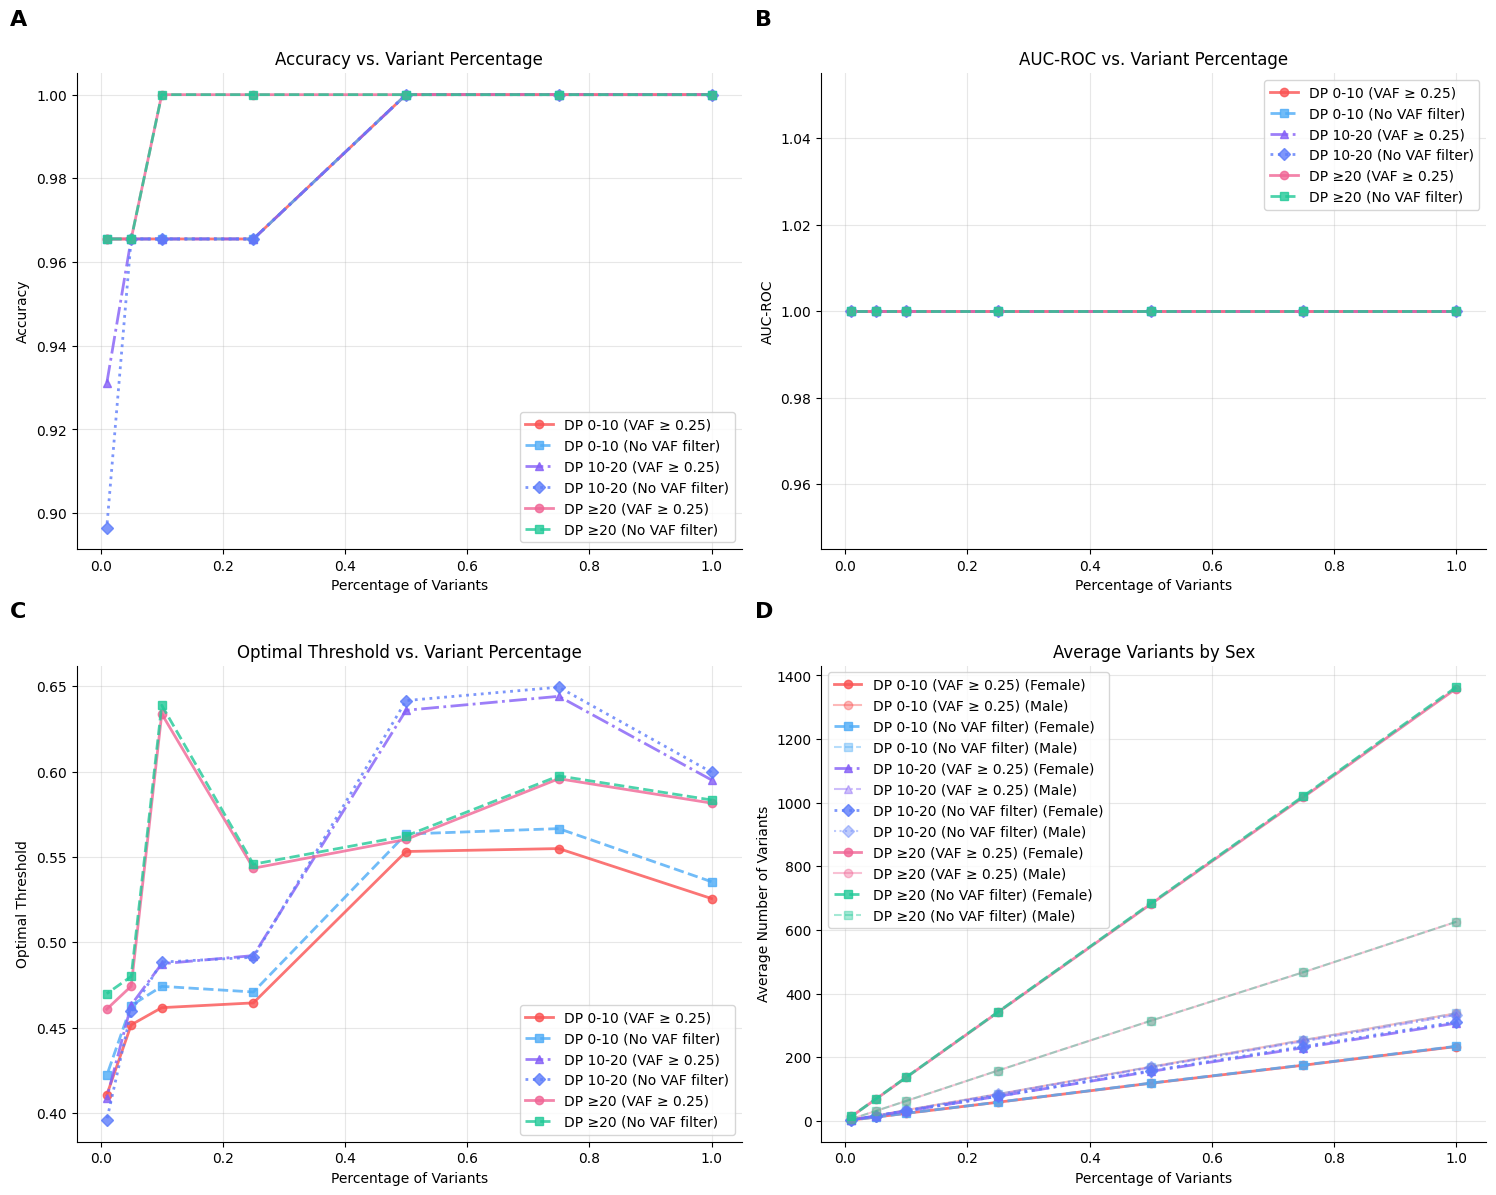

In [ ]:
def plot_comparison_metrics(results):
    """Plot comparison metrics across different depth ranges and variant percentages."""
    # Set font to DejaVu Sans
    plt.rcParams['font.family'] = 'DejaVu Sans'

    # Define color palette
    colors = {
        'red': '#FA5252',  # red5
        'blue': '#4DABF7',  # blue5
        'violet': '#845EF7',  # violet5
        'indigo': '#5C7CFA',  # indigo5
        'pink': '#F06595',  # pink5
        'teal': '#20C997',  # teal5
        'orange': '#FF922B',  # orange5
        'cyan': '#22B8CF',  # cyan5
        'grape': '#CC5DE8',  # grape5
        'green': '#51CF66',  # green5
        'yellow': '#FCC419',  # yellow5
        'lime': '#94D82D',  # lime5
    }

    # Define line styles for different depth ranges
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']

    plt.figure(figsize=(15, 12))

    # Plot accuracy
    ax1 = plt.subplot(221)
    for i, (depth_range, metrics) in enumerate(results.items()):
        percentages = list(metrics.keys())
        accuracies = [m['accuracy'] for m in metrics.values()]
        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        plt.plot(percentages, accuracies, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=depth_range)
    plt.xlabel('Percentage of Variants')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Variant Percentage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold')

    # Plot AUC-ROC
    ax2 = plt.subplot(222)
    for i, (depth_range, metrics) in enumerate(results.items()):
        percentages = list(metrics.keys())
        aucs = [m['auc'] for m in metrics.values()]
        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        plt.plot(percentages, aucs, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=depth_range)
    plt.xlabel('Percentage of Variants')
    plt.ylabel('AUC-ROC')
    plt.title('AUC-ROC vs. Variant Percentage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold')

    # Plot optimal thresholds
    ax3 = plt.subplot(223)
    for i, (depth_range, metrics) in enumerate(results.items()):
        percentages = list(metrics.keys())
        thresholds = [m['optimal_threshold'] for m in metrics.values()]
        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        plt.plot(percentages, thresholds, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=depth_range)
    plt.xlabel('Percentage of Variants')
    plt.ylabel('Optimal Threshold')
    plt.title('Optimal Threshold vs. Variant Percentage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold')

    # Plot average variants by sex
    ax4 = plt.subplot(224)

    # Plot all variants with distinct styles for each depth range
    for i, (depth_range, metrics) in enumerate(results.items()):
        percentages = list(metrics.keys())
        female_variants = [m['avg_female_variants'] for m in metrics.values()]
        male_variants = [m['avg_male_variants'] for m in metrics.values()]
        color = list(colors.values())[i % len(colors)]
        style = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        # Plot female variants
        plt.plot(percentages, female_variants, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.8,
                linewidth=2,
                label=f'{depth_range} (Female)')

        # Plot male variants with same color but different style
        plt.plot(percentages, male_variants, 
                marker=marker, 
                linestyle=style, 
                color=color, 
                alpha=0.4,
                linewidth=1.5,
                label=f'{depth_range} (Male)')

    plt.xlabel('Percentage of Variants')
    plt.ylabel('Average Number of Variants')
    plt.title('Average Variants by Sex')
    plt.legend()
    plt.grid(True, alpha=0.3)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.text(-0.1, 1.1, 'D', transform=ax4.transAxes, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_comparison_metrics(results)